# Цели и задачи проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [1]:
# Загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as skl
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Загружаем данные
stud = pd.read_csv('stud_math.xls')

In [2]:
# Посмотрим, из чего состоит датасет.
display(stud.head(10))
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Данные имеют 13 числовых признаков и 17 номинативных.

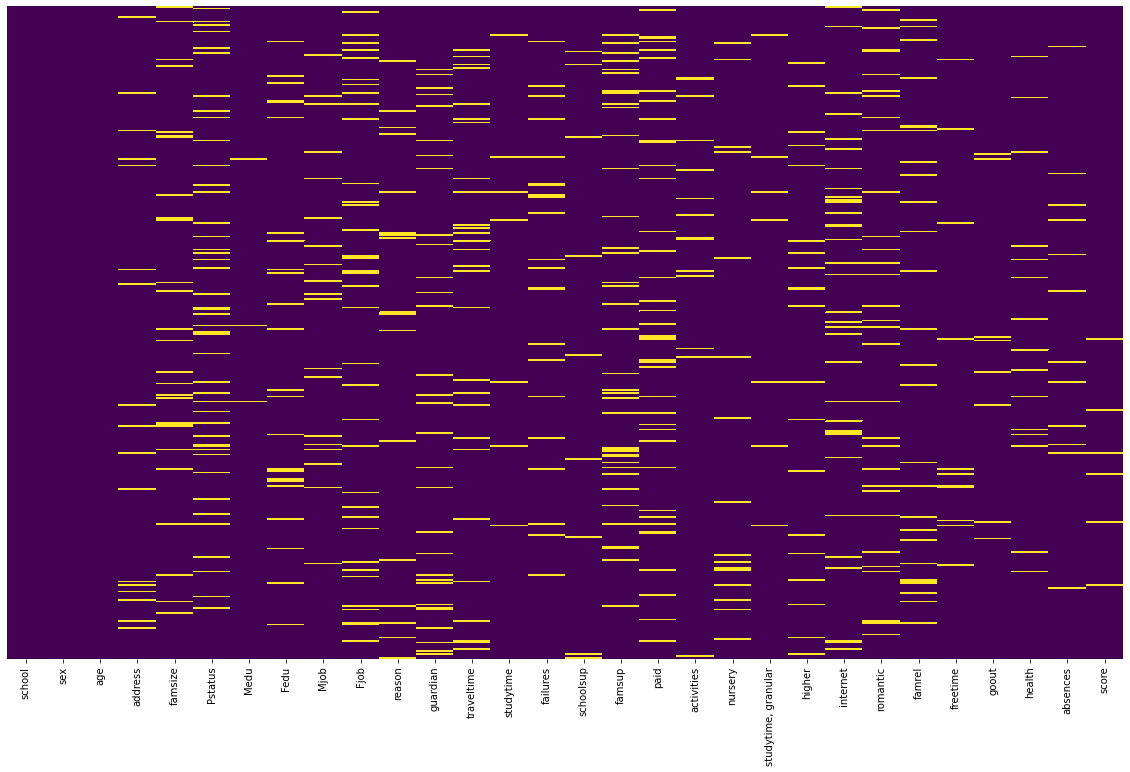

In [3]:
# Визуализируем пропуски с помощью библиотеки Seaborn
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(stud.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Первые три признаки без пропусков, остальные с пропусками.

In [4]:
# Напишем функции, которые можно применять к столбцам определённого типа

def eda_nom(column, bins=None):
    """
    Предобработка номинативных признаков
    """
    column = stud[column]

    # Вывдем статистики
    display(column.describe())

    fig, axs = plt.subplots(nrows=2)

    # Построим гистограмму распределения признака
    sns.countplot(x=column.name, data=stud, ax=axs[0]);

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    # Выведем "ящики с усами"
    sns.boxplot(x=column.name, y='score', data=stud, ax=axs[1])


def eda_num(column, bins=8):
    """
    Предобработка числовых признаков
    """
    column = stud[column]

    # Выведем количество уникальных значений
    print('Количество уникальных значений: {}'.format(column.nunique()))

    # Вывдем статистики
    display(column.describe())

    # Построим гистограмму распределения признака
    if bins == None:
        bins = column.nunique()
    fig, ax = plt.subplots()
    ax.hist(column, bins=bins)
    ax.set_title('Распределение признака {}'.format(column.name, 2))

    # Выведем долю каждого значения признака в столбце в процентах
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    # Визуализируем наличие выбросов
    fig, ax = plt.subplots()
    sns.boxplot(column, orient='v')
    ax.set_title('Визуализация признака {}'.format(column.name, 2))

    # Выведем выбросы
    print('Выбросы:')
    display(outliers_iqr(column))


def outliers_iqr(data):
    """
    Функция нахождения выбросов
    """
    # находим квартили
    quartile_1, quartile_3 = np.percentile(data[~data.isna()], [25, 75])
    # находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    # нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    # верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)

    return [lower_bound, upper_bound]


def replace_by_median(column):
    stud[column] = stud[column].fillna(
        stud.describe(include=['object'])[column].top)


def replace_by_new(column, name):
    stud[column] = stud[column].fillna(name)


def nominative_analisys(stud, col):
    permutations_all = list(combinations(
        stud.loc[:, col].dropna().unique(), 2))
    for perm in permutations_all:
        if ttest_ind(stud.loc[stud.loc[:, col] == perm[0], 'score'].dropna(),
                     stud.loc[stud.loc[:, col] == perm[1], 'score'].dropna()).pvalue \
            <= 0.05/len(permutations_all): #Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col)
            break

In [5]:
column = stud['school']
column.name

'school'

# School
Номинативный признак

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

GP    88.35
MS    11.65
Name: school, dtype: float64

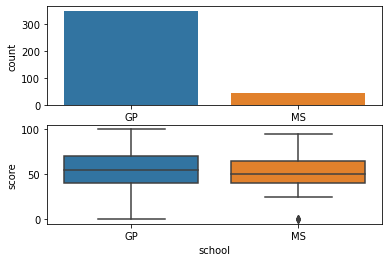

In [6]:
eda_nom('school')

Пропусков нет, два уникальных значения, 88% - GP, остальное - MS.

# sex
Номинативный (бинарный) признак 

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

F    52.66
M    47.34
Name: sex, dtype: float64

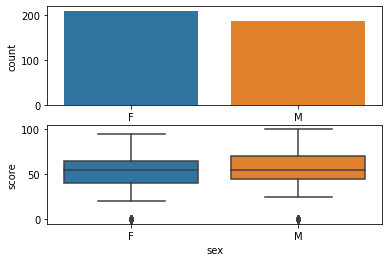

In [7]:
eda_nom('sex')

Пропуски отсутствуют, два уникальных значения.

## age
Числовое значение

Количество уникальных значений: 8


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    26.33
17    24.81
18    20.76
15    20.76
19     6.08
20     0.76
22     0.25
21     0.25
Name: age, dtype: float64

Выбросы:


[13.0, 21.0]

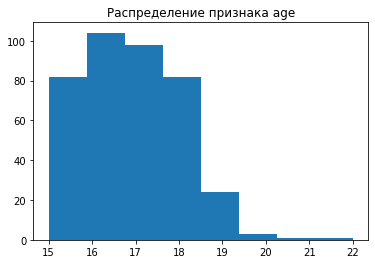

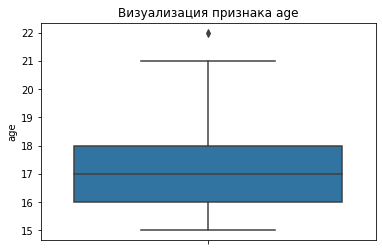

In [8]:
eda_num('age', bins=None)

Количество уникальных значений: 8


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    26.33
17    24.81
18    20.76
15    20.76
19     6.08
20     0.76
22     0.25
21     0.25
Name: age, dtype: float64

Выбросы:


[13.0, 21.0]

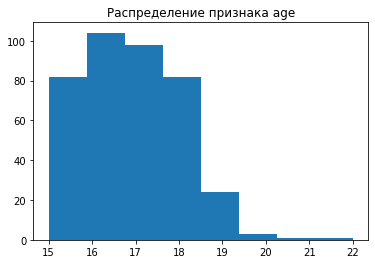

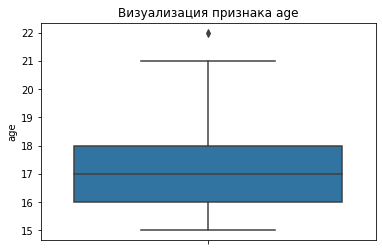

In [9]:
# Проверим, удалился ли выброс
eda_num('age', bins=None)

Числовой признак, имелся один выброс, который мы удалили.

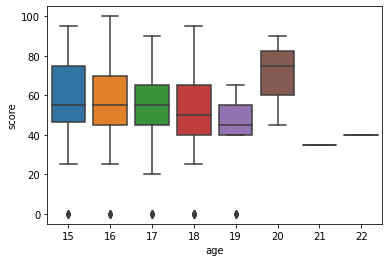

In [10]:
sns.boxplot(y = 'score', x = 'age', data=stud);

## address 
тип адреса ученика ('U' - городской, 'R' - за городом)

count     378
unique      2
top         U
freq      295
Name: address, dtype: object

U      74.68
R      21.01
NaN     4.30
Name: address, dtype: float64

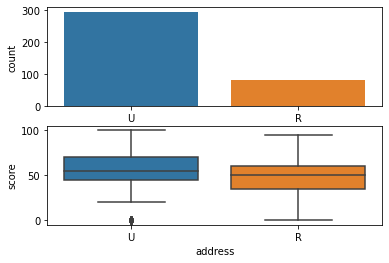

In [11]:
eda_nom('address')

Посмотрим среднее время, которое ученики затрачивают, чтобы добираться до школы, из разных локаций:

In [12]:
stud.groupby(['address', 'school']).traveltime.mean()

address  school
R        GP        1.672727
         MS        2.190476
U        GP        1.319231
         MS        1.529412
Name: traveltime, dtype: float64

Признак категориальный. Как мы видим из нашего распределения, большая часть учеников живут в городе. Вполне логично, что из города до школ добираться быстрее, что и подтвердил анализ среднего значения времени в дороге. Поэтому заменим пропуски на R, если traveltime > 1, а если traveltime = 1, то на U. Если данные в столбце traveltime отсутсвуют - заменим пропуск на U, как на самое часто встречающееся значение.

count     395
unique      2
top         U
freq      306
Name: address, dtype: object

U    77.47
R    22.53
Name: address, dtype: float64

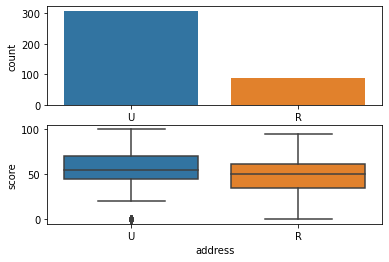

In [13]:
stud['address'] = stud.apply(lambda x: ('R' if x.traveltime > 1 else 'U')\
                             if pd.isna(x.address) else x.address , axis=1)
eda_nom('address')

## famsize
размер семьи('LE3' <= 3, 'GT3' >3)

count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

GT3    66.08
LE3    27.09
NaN     6.84
Name: famsize, dtype: float64

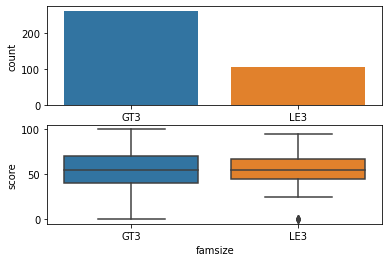

In [14]:
eda_nom('famsize')

Имеется 7% пропусков, заменим их самым часто встречающимся значением.

count     395
unique      2
top       GT3
freq      288
Name: famsize, dtype: object

GT3    72.91
LE3    27.09
Name: famsize, dtype: float64

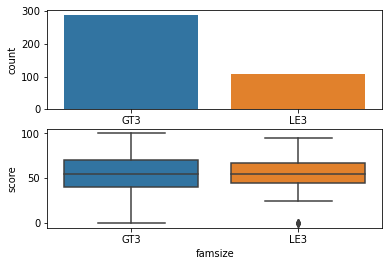

In [15]:
replace_by_median('famsize')
eda_nom('famsize')

## Pstatus
статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

count     350
unique      2
top         T
freq      314
Name: Pstatus, dtype: object

T      79.49
NaN    11.39
A       9.11
Name: Pstatus, dtype: float64

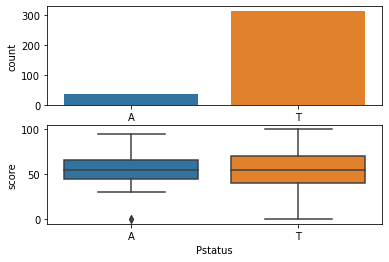

In [16]:
eda_nom('Pstatus')

9% составляют пропуски, создадим новый признак - отсутствующие данные - N.

count     395
unique      3
top         T
freq      314
Name: Pstatus, dtype: object

T    79.49
N    11.39
A     9.11
Name: Pstatus, dtype: float64

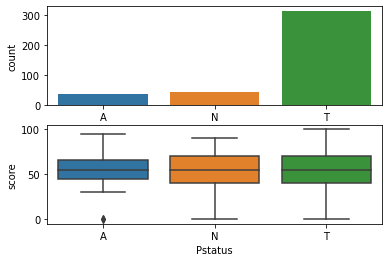

In [17]:
replace_by_new('Pstatus', 'N')
eda_nom('Pstatus')

## Medu
образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). Исходя из смысла - это номинативный признак.

In [18]:
# Проверим корреляцию между образованием матери и отца
stud[['Medu', 'Fedu']].dropna().loc[(stud[['Medu', 'Fedu']].dropna().Medu <= 4)
                                    & (stud[['Medu', 'Fedu']].dropna().Fedu <= 4)].corr()

,Medu,Fedu
Medu,1.000000,0.629956
Fedu,0.629956,1.000000


Видим, что корреляция достаточно высокая. Пропуски и ошибки в образовании отца или матери можно заменять образованием матери и отца соответственно.

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.16
2.0    25.82
3.0    24.56
1.0    14.94
0.0     0.76
NaN     0.76
Name: Medu, dtype: float64

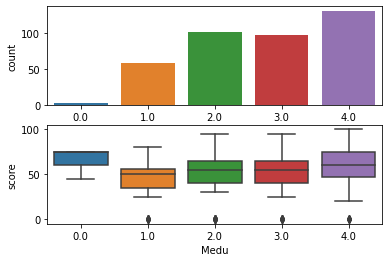

In [19]:
eda_nom('Medu')

0.8% составляют пропуски, заменим из на образование отца.

count    395.000000
mean       2.744304
std        1.098193
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

4.0    33.16
2.0    26.08
3.0    24.81
1.0    15.19
0.0     0.76
Name: Medu, dtype: float64

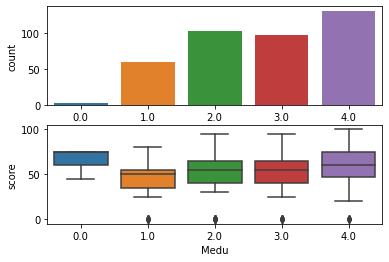

In [20]:
stud.Medu = stud.Medu.fillna(stud.Fedu)
eda_nom('Medu')

## Fedu
образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

2.0     26.84
3.0     24.30
4.0     22.28
1.0     19.75
NaN      6.08
0.0      0.51
40.0     0.25
Name: Fedu, dtype: float64

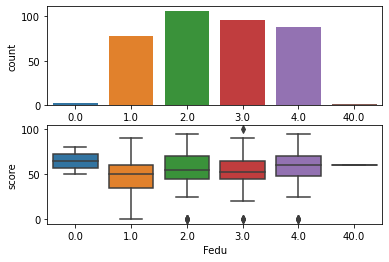

In [21]:
eda_nom('Fedu')

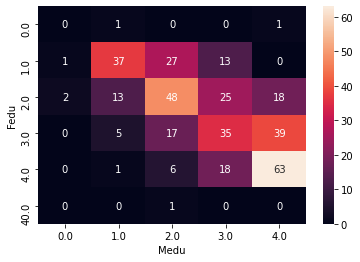

In [22]:
sns.heatmap(pd.crosstab(stud.Fedu, stud.Medu), annot=True);

Имеется ошибка - значение 40, заменим её и пропуски на образование матери.

In [23]:
stud.Fedu = stud.Fedu.apply(lambda x: None if x>4 else x)
stud.Fedu = stud.Fedu.fillna(stud.Medu)

count    395.000000
mean       2.541772
std        1.089941
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

2.0    28.10
3.0    26.08
4.0    24.81
1.0    20.51
0.0     0.51
Name: Fedu, dtype: float64

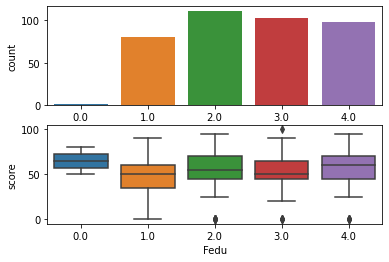

In [24]:
# Проверим результаты
eda_nom('Fedu')

## Mjob
работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       376
unique        5
top       other
freq        133
Name: Mjob, dtype: object

other       33.67
services    24.81
at_home     14.68
teacher     13.92
health       8.10
NaN          4.81
Name: Mjob, dtype: float64

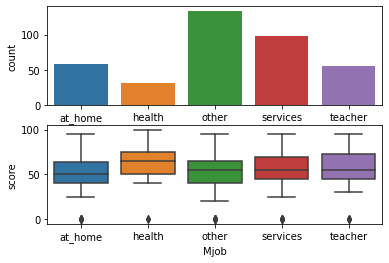

In [25]:
eda_nom('Mjob')

Заполним пропуски значением "other"

In [26]:
stud.Mjob = stud.Mjob.fillna('other')

count       395
unique        5
top       other
freq        152
Name: Mjob, dtype: object

other       38.48
services    24.81
at_home     14.68
teacher     13.92
health       8.10
Name: Mjob, dtype: float64

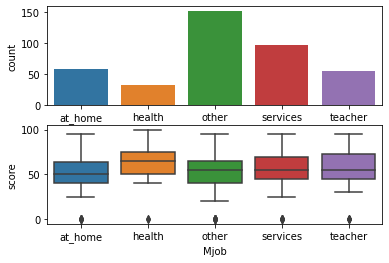

In [27]:
eda_nom('Mjob')

# Fjob - работа отца

 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

count       359
unique        5
top       other
freq        197
Name: Fjob, dtype: object

other       49.87
services    25.82
NaN          9.11
teacher      7.34
at_home      4.05
health       3.80
Name: Fjob, dtype: float64

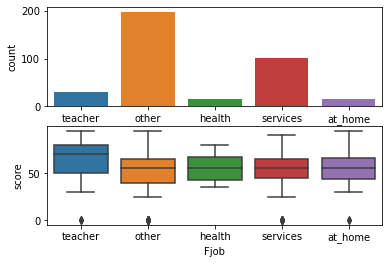

In [28]:
eda_nom('Fjob')

Заполним пропуски значением "other"

In [29]:
stud.Fjob = stud.Fjob.fillna('other')

# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

course        34.68
home          26.33
reputation    26.08
other          8.61
NaN            4.30
Name: reason, dtype: float64

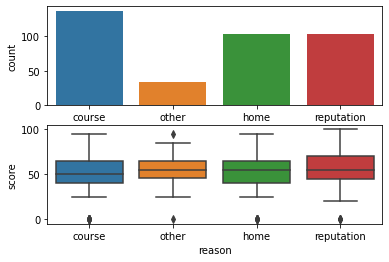

In [30]:
eda_nom('reason')

In [31]:
# сделаем замену пустых значений на самое часто встречающееся значение - course
stud['reason'] = stud['reason'].fillna(
    stud.describe(include=['object']).reason.top)

count        395
unique         4
top       course
freq         154
Name: reason, dtype: object

course        38.99
home          26.33
reputation    26.08
other          8.61
Name: reason, dtype: float64

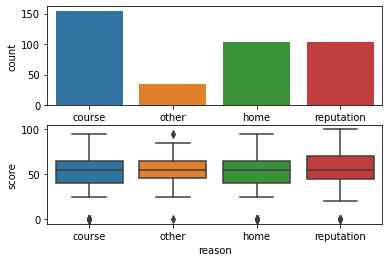

In [32]:
eda_nom('reason')

# 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

mother    63.29
father    21.77
NaN        7.85
other      7.09
Name: guardian, dtype: float64

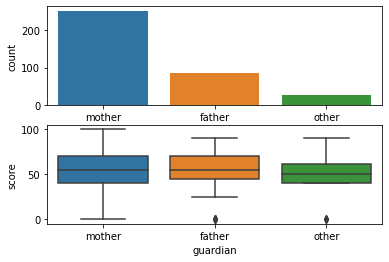

In [33]:
eda_nom('guardian')

Заполним пропуски наиболее часто встречающимся значением

count        395
unique         3
top       mother
freq         281
Name: guardian, dtype: object

mother    71.14
father    21.77
other      7.09
Name: guardian, dtype: float64

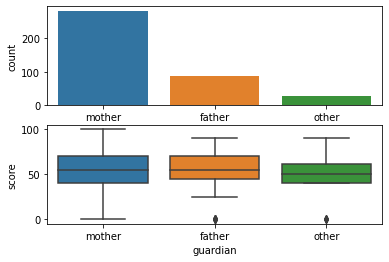

In [34]:
stud.guardian = stud.guardian.fillna(
    stud.describe(include=['object']).guardian.top)
eda_nom('guardian')

# 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Ординальный признак

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

1.0    61.27
2.0    24.30
NaN     7.09
3.0     5.57
4.0     1.77
Name: traveltime, dtype: float64

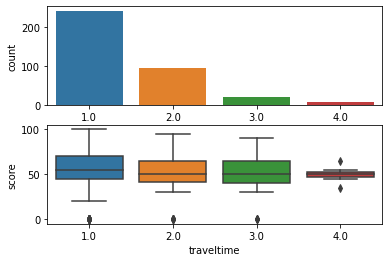

In [35]:
eda_nom('traveltime')

Посмотрим среднее время ученика до школы, чтобы заполнить пропуски

In [36]:
stud.groupby(['address', 'school']).traveltime.mean()

address  school
R        GP        1.684211
         MS        2.200000
U        GP        1.309701
         MS        1.529412
Name: traveltime, dtype: float64

Заменим пропуски следующим образом: присвоим 2, если ученик живёт в пригороде, и 1, если ученик живёт в городе 

count    395.000000
mean       1.425316
std        0.680674
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

1.0    66.58
2.0    26.08
3.0     5.57
4.0     1.77
Name: traveltime, dtype: float64

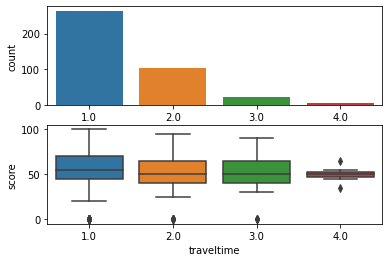

In [37]:
stud.traveltime = stud.apply(lambda x: (2 if x.address == 'R' else 1)
                             if pd.isna(x.traveltime) else x.traveltime, axis=1)
eda_nom('traveltime')

# studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

2.0    49.11
1.0    26.08
3.0    16.20
4.0     6.84
NaN     1.77
Name: studytime, dtype: float64

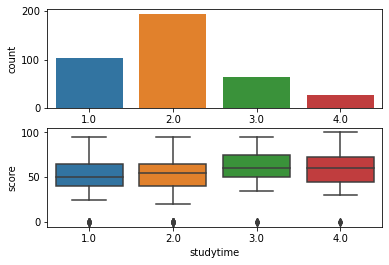

In [38]:
eda_nom('studytime')

Заполним пропуски самым частым значением

count    395.000000
mean       2.037975
std        0.834580
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

2.0    50.89
1.0    26.08
3.0    16.20
4.0     6.84
Name: studytime, dtype: float64

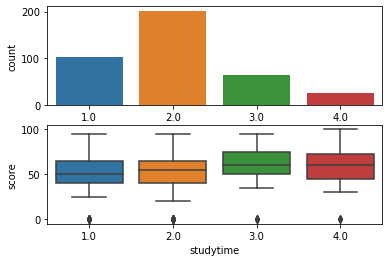

In [39]:
stud.studytime = stud.studytime.fillna(
    stud.describe().studytime['50%'])
eda_nom('studytime')

# 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

0.0    74.18
1.0    12.41
NaN     5.57
2.0     4.05
3.0     3.80
Name: failures, dtype: float64

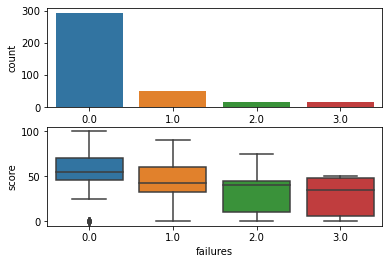

In [40]:
eda_nom('failures')

Заполним пропуски самым частым значением.

count    395.000000
mean       0.318987
std        0.726244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

0.0    79.75
1.0    12.41
2.0     4.05
3.0     3.80
Name: failures, dtype: float64

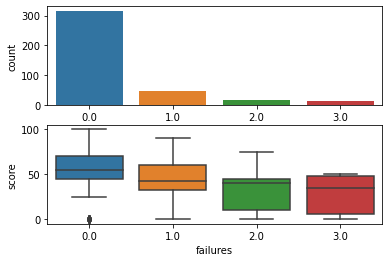

In [41]:
stud.failures = stud.failures.fillna(
    stud.describe().failures['50%'])
eda_nom('failures')

# 16 schoolsup — дополнительная образовательная поддержка (yes или no)

count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

no     84.81
yes    12.91
NaN     2.28
Name: schoolsup, dtype: float64

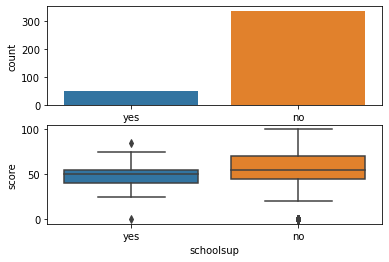

In [42]:
eda_nom('schoolsup')

Заполним пропуски самым частым значением.

count     395
unique      2
top        no
freq      344
Name: schoolsup, dtype: object

no     87.09
yes    12.91
Name: schoolsup, dtype: float64

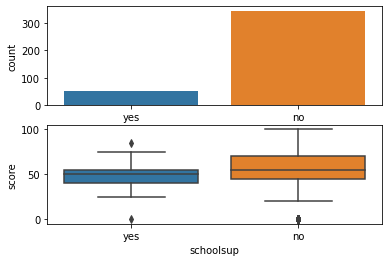

In [43]:
stud['schoolsup'] = stud['schoolsup'].fillna(
    stud.describe(include=['object']).schoolsup.top)
eda_nom('schoolsup')

# 17 famsup — семейная образовательная поддержка (yes или no)

count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

yes    55.44
no     34.68
NaN     9.87
Name: famsup, dtype: float64

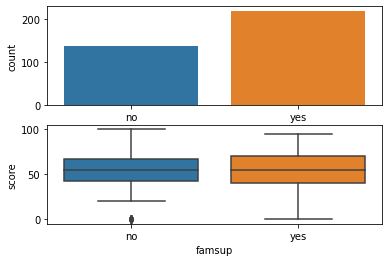

In [44]:
eda_nom('famsup')

Посмотрим, как зависит семейная образовательная поддержка и образование родителей.

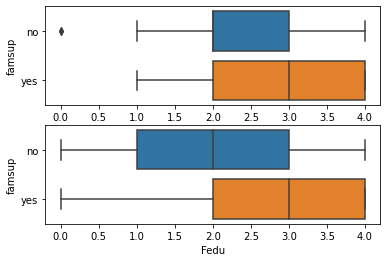

In [45]:
fig, axs = plt.subplots(2,1)
sns.boxplot(x='Medu', y='famsup', data=stud, ax=axs[0])
sns.boxplot(x='Fedu', y='famsup', data=stud, ax=axs[1]);

Заполним пропуски следующим образом: семейная образовательная поддержка есть, если образование отца больше или равно 3.

count     395
unique      2
top       yes
freq      235
Name: famsup, dtype: object

yes    59.49
no     40.51
Name: famsup, dtype: float64

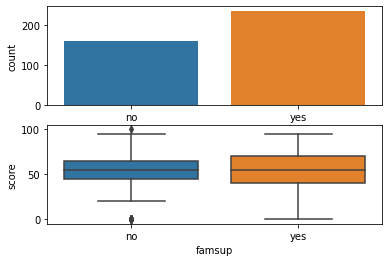

In [46]:
stud.famsup = stud.apply(lambda x: ('yes' if x.Fedu >= 3 else 'no')
                             if pd.isna(x.famsup) else x.famsup, axis=1)
eda_nom('famsup')

# 18 paid — дополнительные платные занятия по математике (yes или no)

count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

no     50.63
yes    39.24
NaN    10.13
Name: paid, dtype: float64

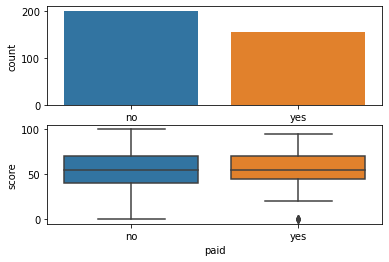

In [47]:
eda_nom('paid')

Заполним пропуски значением 'other'.

count     395
unique      3
top        no
freq      200
Name: paid, dtype: object

no       50.63
yes      39.24
other    10.13
Name: paid, dtype: float64

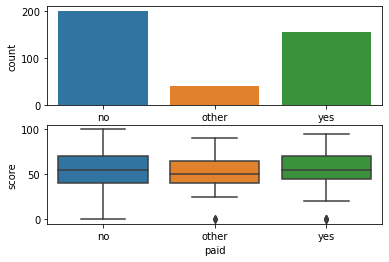

In [48]:
stud.paid = stud.paid.fillna('other')
eda_nom('paid')

# 19 activities — дополнительные внеучебные занятия (yes или no)

count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

yes    49.37
no     47.09
NaN     3.54
Name: activities, dtype: float64

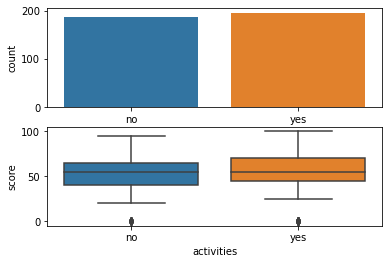

In [49]:
eda_nom('activities')

Заполним пропуски случайным образом.

count     395
unique      2
top       yes
freq      209
Name: activities, dtype: object

yes    52.91
no     47.09
Name: activities, dtype: float64

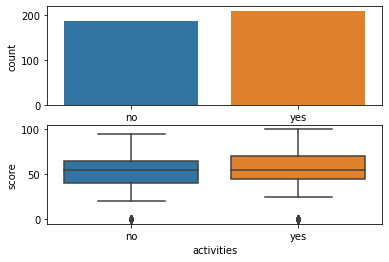

In [50]:
import random
stud.activities = stud.activities.fillna(random.choice(['yes', 'no']))
eda_nom('activities')

# 20 nursery — посещал детский сад (yes или no)

count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

yes    75.95
no     20.00
NaN     4.05
Name: nursery, dtype: float64

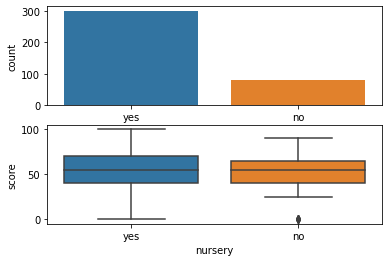

In [51]:
eda_nom('nursery')

Заполним пропуски значением 'yes'.

count     395
unique      2
top       yes
freq      316
Name: nursery, dtype: object

yes    80.0
no     20.0
Name: nursery, dtype: float64

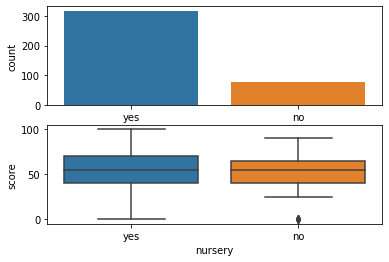

In [52]:
stud.nursery = stud.nursery.fillna('yes')
eda_nom('nursery')

# 21 higher — хочет получить высшее образование (yes или no)

count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

yes    90.13
NaN     5.06
no      4.81
Name: higher, dtype: float64

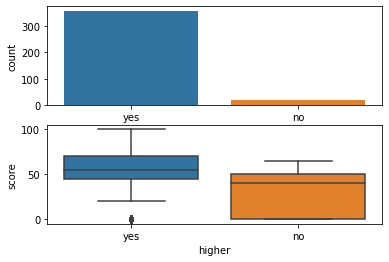

In [53]:
eda_nom('higher')

Заполним пропуски значением 'yes'.

count     395
unique      2
top       yes
freq      376
Name: higher, dtype: object

yes    95.19
no      4.81
Name: higher, dtype: float64

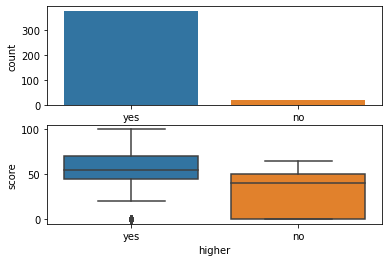

In [54]:
stud.higher = stud.higher.fillna('yes')
eda_nom('higher')

# studytime, granular

count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

-6.0     49.11
-3.0     26.08
-9.0     16.20
-12.0     6.84
 NaN      1.77
Name: studytime, granular, dtype: float64

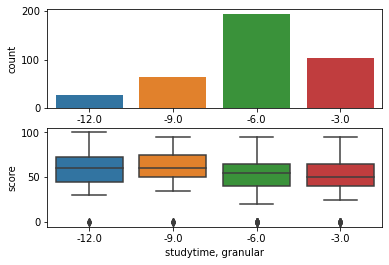

In [55]:
eda_nom('studytime, granular')

In [56]:
stud.corr()['studytime, granular']

age                    0.015556
Medu                  -0.077671
Fedu                   0.000442
traveltime             0.101153
studytime             -1.000000
failures               0.168020
studytime, granular    1.000000
famrel                -0.045894
freetime               0.121969
goout                  0.051280
health                 0.080016
absences               0.026544
score                 -0.115741
Name: studytime, granular, dtype: float64

In [57]:
del stud['studytime, granular']

# 22 internet — наличие интернета дома (yes или no)

count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

yes    77.22
no     14.18
NaN     8.61
Name: internet, dtype: float64

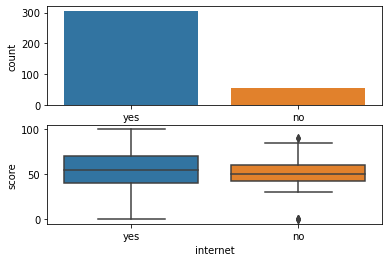

In [58]:
eda_nom('internet')

count     395
unique      2
top       yes
freq      339
Name: internet, dtype: object

yes    85.82
no     14.18
Name: internet, dtype: float64

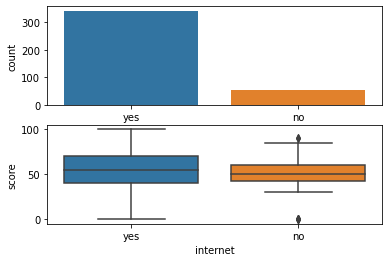

In [59]:
stud.internet = stud.internet.fillna('yes')
eda_nom('internet')

# 23 romantic — в романтических отношениях (yes или no)

count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

no     60.76
yes    31.39
NaN     7.85
Name: romantic, dtype: float64

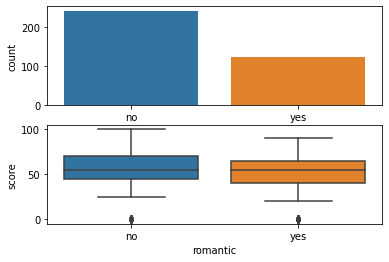

In [60]:
eda_nom('romantic')

count     395
unique      2
top        no
freq      271
Name: romantic, dtype: object

no     68.61
yes    31.39
Name: romantic, dtype: float64

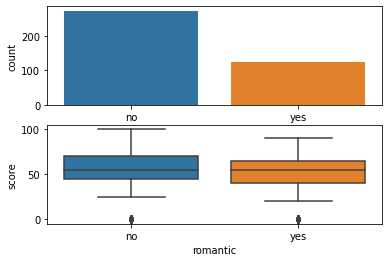

In [61]:
stud.romantic = stud.romantic.fillna('no')
eda_nom('romantic')

# 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

 4.0    46.08
 5.0    25.06
 3.0    15.70
 NaN     6.84
 2.0     4.30
 1.0     1.77
-1.0     0.25
Name: famrel, dtype: float64

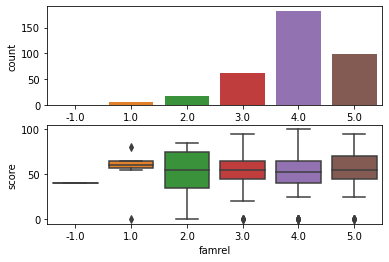

In [62]:
eda_nom('famrel')

count    395.000000
mean       3.941772
std        0.895081
min       -1.000000
25%        4.000000
50%        4.000000
75%        4.500000
max        5.000000
Name: famrel, dtype: float64

 4.0    52.91
 5.0    25.06
 3.0    15.70
 2.0     4.30
 1.0     1.77
-1.0     0.25
Name: famrel, dtype: float64

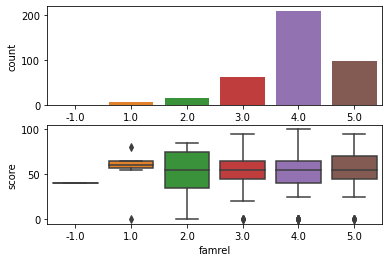

In [63]:
stud.famrel = stud.famrel.fillna(
    stud.describe().famrel['50%'])
eda_nom('famrel')

# 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

3.0    38.73
4.0    28.35
2.0    15.95
5.0     9.62
1.0     4.56
NaN     2.78
Name: freetime, dtype: float64

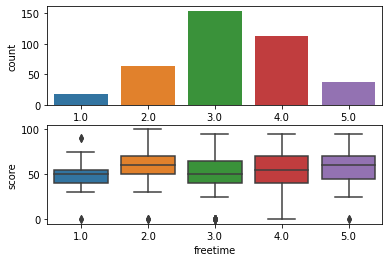

In [64]:
eda_nom('freetime')

count    395.000000
mean       3.225316
std        0.980711
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

3.0    41.52
4.0    28.35
2.0    15.95
5.0     9.62
1.0     4.56
Name: freetime, dtype: float64

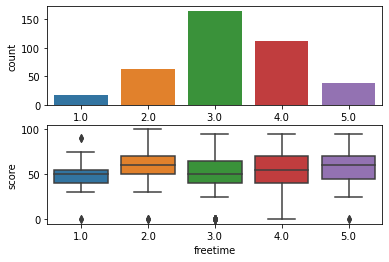

In [65]:
stud.freetime = stud.freetime.fillna(
    stud.describe().freetime['50%'])
eda_nom('freetime')

# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

3.0    32.15
2.0    25.57
4.0    21.27
5.0    13.16
1.0     5.82
NaN     2.03
Name: goout, dtype: float64

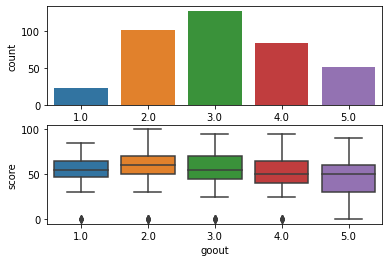

In [66]:
eda_nom('goout')

count    395.000000
mean       3.103797
std        1.104610
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

3.0    34.18
2.0    25.57
4.0    21.27
5.0    13.16
1.0     5.82
Name: goout, dtype: float64

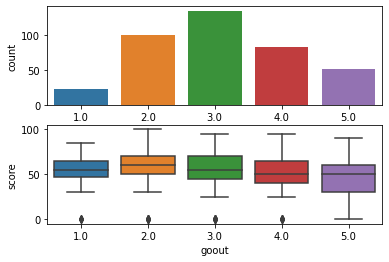

In [67]:
stud.goout = stud.goout.fillna(
    stud.describe().goout['50%'])
eda_nom('goout')

# 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

5.0    34.94
3.0    22.53
4.0    15.95
1.0    11.90
2.0    10.89
NaN     3.80
Name: health, dtype: float64

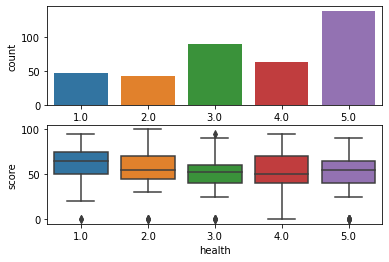

In [68]:
eda_nom('health')

count    395.000000
mean       3.549367
std        1.372118
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

5.0    34.94
3.0    22.53
4.0    19.75
1.0    11.90
2.0    10.89
Name: health, dtype: float64

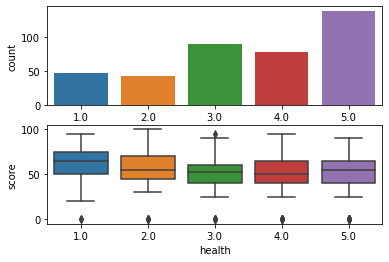

In [69]:
stud.health = stud.health.fillna(
    stud.describe().health['50%'])
eda_nom('health')

# 28 absences — количество пропущенных занятий

Количество уникальных значений: 36


count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


0.0      28.10
2.0      15.19
4.0      13.42
6.0       7.85
8.0       5.32
10.0      4.30
12.0      3.04
NaN       3.04
14.0      3.04
3.0       2.03
16.0      1.77
7.0       1.52
5.0       1.27
18.0      1.27
20.0      1.01
1.0       0.76
22.0      0.76
9.0       0.76
13.0      0.51
15.0      0.51
11.0      0.51
25.0      0.25
54.0      0.25
385.0     0.25
26.0      0.25
56.0      0.25
24.0      0.25
212.0     0.25
21.0      0.25
75.0      0.25
30.0      0.25
19.0      0.25
38.0      0.25
40.0      0.25
23.0      0.25
17.0      0.25
28.0      0.25
Name: absences, dtype: float64

Выбросы:


[-12.0, 20.0]

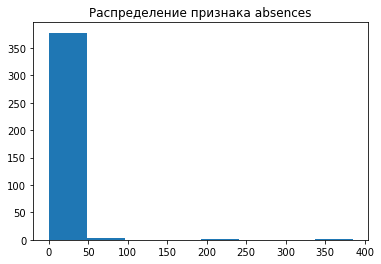

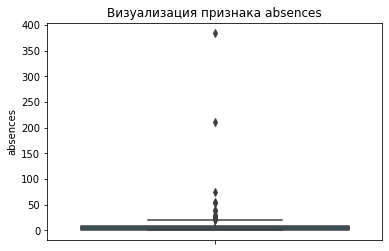

In [70]:
eda_num('absences')

In [71]:
outliers_iqr(stud.absences)[0]

-12.0

Оставим только строки, где значение не более 30.

In [72]:
stud = stud.loc[stud.absences.between(outliers_iqr(stud.absences)[0], 30)]

Количество уникальных значений: 29


count    376.000000
mean       5.127660
std        5.854656
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

0.0     29.52
2.0     15.96
4.0     14.10
6.0      8.24
8.0      5.59
10.0     4.52
12.0     3.19
14.0     3.19
3.0      2.13
16.0     1.86
7.0      1.60
5.0      1.33
18.0     1.33
20.0     1.06
22.0     0.80
1.0      0.80
9.0      0.80
13.0     0.53
11.0     0.53
15.0     0.53
17.0     0.27
25.0     0.27
26.0     0.27
23.0     0.27
28.0     0.27
21.0     0.27
30.0     0.27
19.0     0.27
24.0     0.27
Name: absences, dtype: float64

Выбросы:


[-12.0, 20.0]

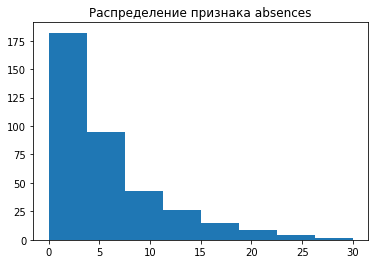

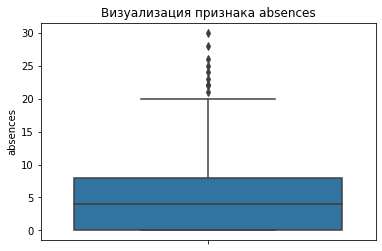

In [73]:
eda_num('absences')

# 29 score — баллы по госэкзамену по математике

Количество уникальных значений: 18


count    371.00000
mean      52.03504
std       22.92989
min        0.00000
25%       40.00000
50%       55.00000
75%       70.00000
max      100.00000
Name: score, dtype: float64

C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


50.0     14.10
55.0     11.70
0.0       9.57
65.0      8.24
75.0      8.24
60.0      7.71
40.0      7.18
70.0      7.18
45.0      6.65
80.0      4.26
30.0      3.99
90.0      2.93
35.0      2.39
25.0      1.86
95.0      1.33
NaN       1.33
85.0      0.80
100.0     0.27
20.0      0.27
Name: score, dtype: float64

Выбросы:


[-5.0, 115.0]

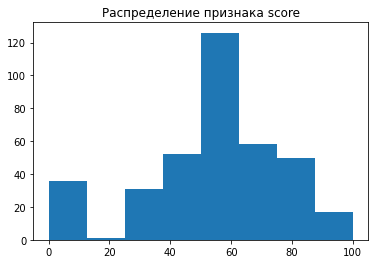

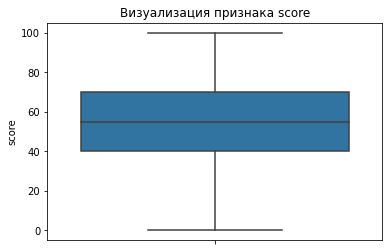

In [74]:
eda_num('score')

Удалим пропуски.

In [75]:
stud = stud.dropna(subset=['score'])

Количество уникальных значений: 18


count    371.00000
mean      52.03504
std       22.92989
min        0.00000
25%       40.00000
50%       55.00000
75%       70.00000
max      100.00000
Name: score, dtype: float64

50.0     14.29
55.0     11.86
0.0       9.70
75.0      8.36
65.0      8.36
60.0      7.82
70.0      7.28
40.0      7.28
45.0      6.74
80.0      4.31
30.0      4.04
90.0      2.96
35.0      2.43
25.0      1.89
95.0      1.35
85.0      0.81
100.0     0.27
20.0      0.27
Name: score, dtype: float64

Выбросы:


[-5.0, 115.0]

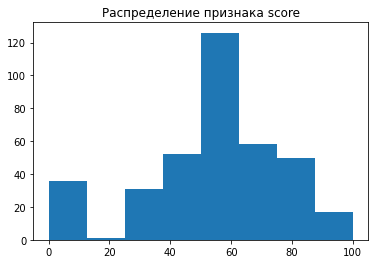

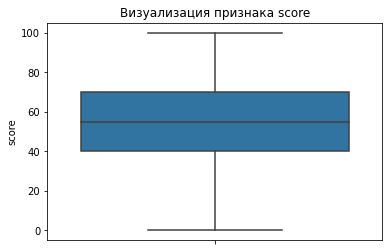

In [76]:
eda_num('score')

# Корреляционный анализ

In [77]:
num_col = ['age', 'absences', 'score']
bin_col = ['school', 'sex', 'address', 'famsize', 'Pstatus',
           'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime',
           'goout', 'health']
cat_col = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason',
           'guardian', 'traveltime', 'studytime', 'failures']

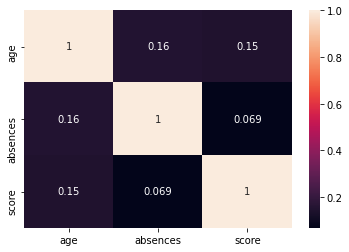

In [78]:
sns.heatmap(stud[num_col].corr().abs(), annot=True);

Корреляция слабая

In [79]:
for col in bin_col + cat_col:
    nominative_analisys(stud[stud.score>0], col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures


C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\gdoku\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\gdoku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [93]:
for column in stud.columns:
    for val in stud[column].unique():
        m = (stud.loc[stud[column] == val, 'score'] == 0).mean()
        if m > 0.2:
            print(column, val, m)

age 19 0.2631578947368421
failures 3.0 0.23076923076923078
failures 2.0 0.2857142857142857
failures 1.0 0.2222222222222222
higher no 0.3125
absences 0.0 0.32727272727272727
score 0.0 1.0


# Итоги работы

В результате EDA для анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:

- В данных немного пустых значений (не более 10% в одном столбце). Данные были заполнены.
- Выявлена корреляция между параметром score и age, address, schoolsup, goout, Medu, Fedu, Mjob, studytime, failures